# Why Can a Coefficient Become Negative in Multiple Linear Regression
# When Its Bivariate Relationship Is Clearly Positive?

One of the deepest and most frequently misunderstood concepts in multiple linear regression:

> The regression coefficient is **not** the simple bivariate slope.
> It is the **partial effect** of that variable **while holding all other predictors constant**.

When severe multicollinearity exists, "holding all other predictors constant" becomes a counterfactual — often physically impossible — scenario. In such cases, the sign of the coefficient can completely reverse.

We demonstrate this using the classic Canadian **FuelConsumptionCo2** dataset.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

### Load the dataset

In [3]:
df = pd.read_csv("/home/pyrz-tech/Desktop/MachineLearning/FuelConsumptionCo2.csv")
df.head()

,MODELYEAR,MAKE,MODEL,VEHICLECLASS,ENGINESIZE,CYLINDERS,TRANSMISSION,FUELTYPE,FUELCONSUMPTION_CITY,FUELCONSUMPTION_HWY,FUELCONSUMPTION_COMB,FUELCONSUMPTION_COMB_MPG,CO2EMISSIONS
0,2014,ACURA,ILX,COMPACT,2.0,4,AS5,Z,9.9,6.7,8.5,33,196
1,2014,ACURA,ILX,COMPACT,2.4,4,M6,Z,11.2,7.7,9.6,29,221
2,2014,ACURA,ILX HYBRID,COMPACT,1.5,4,AV7,Z,6.0,5.8,5.9,48,136
3,2014,ACURA,MDX 4WD,SUV - SMALL,3.5,6,AS6,Z,12.7,9.1,11.1,25,255
4,2014,ACURA,RDX AWD,SUV - SMALL,3.5,6,AS6,Z,12.1,8.7,10.6,27,244


### Select features and target

In [4]:
features = ['ENGINESIZE', 'CYLINDERS', 'FUELCONSUMPTION_COMB',
            'FUELCONSUMPTION_CITY', 'FUELCONSUMPTION_HWY']
target = 'CO2EMISSIONS'

X = df[features]
y = df[target]

### Train/test split

In [5]:
np.random.seed(42)
msk = np.random.rand(len(df)) < 0.8
train = df[msk]
test = df[~msk]

print(f"Train size: {len(train)}, Test size: {len(test)}")

Train size: 848, Test size: 219


### Fit multiple linear regression

In [6]:
reg = LinearRegression()
reg.fit(train[features], train[target])

print("Coefficients:", reg.coef_.round(3))
print("Intercept:   ", reg.intercept_.round(3))

Coefficients: [ 10.962   7.25  -10.937  12.227   8.104]
Intercept:    65.076


### Model performance

In [7]:
pred = reg.predict(test[features])
r2 = r2_score(test[target], pred)
print(f"R² on test set: {r2:.4f}")

R² on test set: 0.8712


### The diagnostic plot that reveals everything

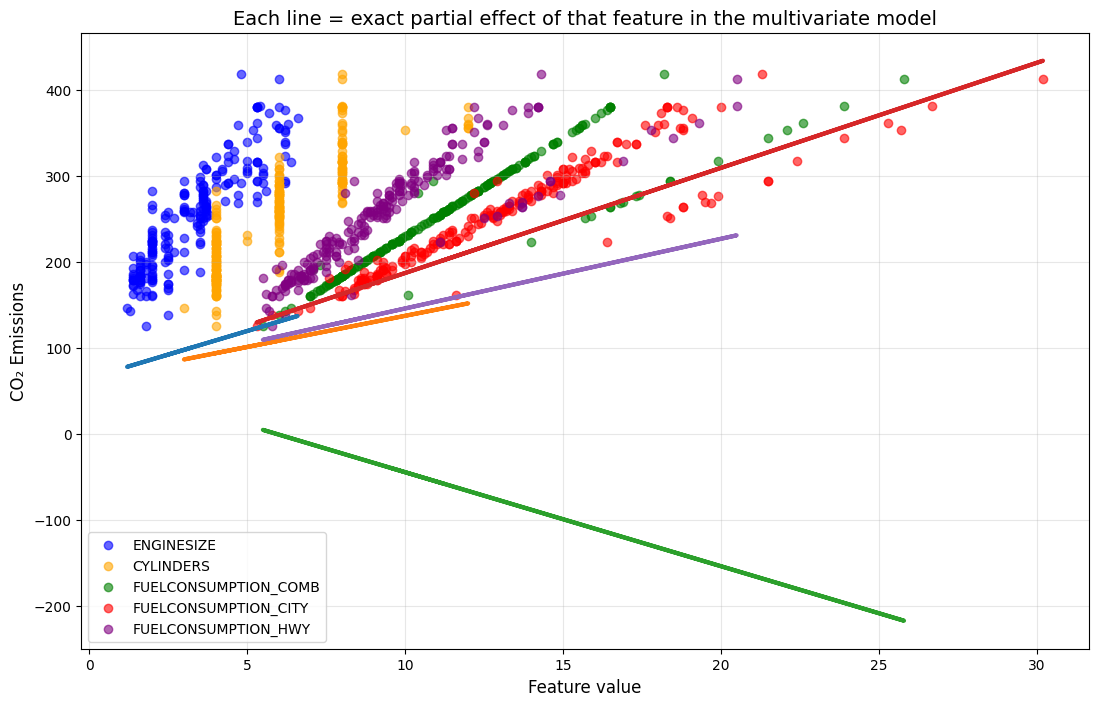

In [8]:
plt.figure(figsize=(13, 8))

colors = ['blue', 'orange', 'green', 'red', 'purple']
labels = features

for i, col in enumerate(features):
    plt.scatter(test[col], test[target], color=colors[i], alpha=0.6, label=labels[i])

# The magic (technically "wrong") line that draws the exact multivariate coefficients
plt.plot(test[features].values,
         reg.coef_ * test[features].values + reg.intercept_,
         linewidth=3)

plt.xlabel('Feature value', fontsize=12)
plt.ylabel('CO₂ Emissions', fontsize=12)
plt.title('Each line = exact partial effect of that feature in the multivariate model', fontsize=14)
plt.legend()
plt.grid(alpha=0.3)
plt.show()

### Why the sign reversal happens

The three fuel consumption variables are nearly perfectly collinear:

```
FUELCONSUMPTION_COMB ≈ 0.55 × CITY + 0.45 × HWY
```

In real data, you almost never observe a change in CITY or HWY while COMB stays fixed.

The regression coefficient for HWY answers the question:
> "What happens to CO₂ if I increase HWY **while holding COMB, CITY, and all other variables constant**?"

That scenario is physically almost impossible → the coefficient becomes negative purely as a mathematical compensation mechanism.

This is known as **sign reversal due to severe multicollinearity** (or the suppressor effect).

### Key takeaways

1. High R² + unexpected coefficient signs → almost always severe multicollinearity
2. In severe multicollinearity, coefficients lose causal interpretability
3. The plot above is one of the clearest diagnostic and teaching tools for this phenomenon